# Introduction

This Jupyter Notebook contains code for data analysis and processing

In [1]:
import re
import pandas as pd
from math import log10
import matplotlib.pyplot as plt
from utils import *
import os

In [6]:
BASE_FOLDER = "../out/021624"
JOBS_LIST = [BASE_FOLDER + "/" + job for job in os.listdir(BASE_FOLDER)]

print(JOBS_LIST)
print("# of jobs: ", len(JOBS_LIST))
df_total = getTotalResults(JOBS_LIST)

['../out/021624/42302732', '../out/021624/42302735', '../out/021624/42302738', '../out/021624/42302733', '../out/021624/42302742', '../out/021624/42302736', '../out/021624/42302745', '../out/021624/42302739', '../out/021624/42302740', '../out/021624/42302743', '../out/021624/42302752', '../out/021624/42302746', '../out/021624/42302749', '../out/021624/42302750', '../out/021624/42302753', '../out/021624/42302756', '../out/021624/42302734', '../out/021624/42302737', '../out/021624/42302741', '../out/021624/42302744', '../out/021624/42302747', '../out/021624/42302751', '../out/021624/42302754', '../out/021624/42302748', '../out/021624/42302755']
# of jobs:  25


In [8]:
#sort df_total by k
df_total = df_total.sort_values(by=['k'])
df_total.columns

Index(['k', 'thres', 'target', '1_readFastaFile', '1_computeKmerTable',
       '1_save', '1_Memory usage', '1_pick Memory usage', '2_GenCryptoContext',
       '2_KeyGen', '2_Serialize', '2_context', '2_public', '2_private',
       '2_eval-mult', '2_Memory usage', '2_Pick Memory usage', 'n_kmer_total',
       '3_readFastaFile', '3_load_kmerList', '3_encodeRead',
       '3_EncryptReadKmer', '3_serializeCtxtRead', '3_Memory usage',
       '3_Pick Memory usage', 'n_gene', '4_loadKmerTable', '4_loadKmerList',
       '4_encodeReference', '4_readCtxtRead', '4_multCtxtByEncodedRef',
       '4_serializeCtxtOut', '4_Memory usage', '4_Memory_per_gene',
       '4_Pick Memory usage', '5_loadKmerTable', '5_readCtxtOut',
       '5_decryptOutput', '5_Memory usage', '5_Pick Memory usage', 'job',
       'n_genes', 'num_batch'],
      dtype='object')

In [9]:
PARAMS = ['k', 'thres', 'target', 'n_genes', 'num_batch', 'n_kmer_total']
SERVER_PREPROCESS = ["1_computeKmerTable", "4_encodeReference"]
SERVER_COPMUTATION = ["4_multCtxtByEncodedRef"]
SERVER_SAVE_LOAD = ["1_readFastaFile", "1_save", "4_loadKmerTable", "4_loadKmerList", "4_serializeCtxtOut"]
SERVER_MEMORY = ["1_Memory usage", "1_pick Memory usage", "4_Memory usage", "4_Pick Memory usage"]

USER_HE_GEN = ["2_GenCryptoContext", "2_KeyGen"]
USER_ENCRYPT = ["3_encodeRead", "3_EncryptReadKmer"]
USER_DECRYPT = ["5_decryptOutput"]
USER_SAVE_LOAD = ["2_Serialize", "3_load_kmerList", "3_readFastaFile", "3_serializeCtxtRead", "5_loadKmerTable", "5_readCtxtOut"]
USER_MEMORY = ["2_Memory usage", "2_Pick Memory usage", "3_Memory usage", "3_Pick Memory usage", "5_Memory usage", "5_Pick Memory usage"]

In [10]:
def plotEachColumn(df, col, title):
    plt.figure()
    for thres in df['thres'].unique():
        df_thres = df[df['thres'] == thres]
        plt.plot(df_thres['k'], df_thres[col], label=thres)
    plt.title(col)
    plt.xlabel('k')
    plt.ylabel(param)
    plt.xlim(10, 30)
    plt.legend()
    plt.savefig(os.path.join(PLOT_DIR, title + ".png"))
    plt.show()
    
PLOT_DIR = "plot"

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e-01     1.0   5000.0        250    61164530.0   
0  25.0  1.000000e-05     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e+02     1.0   5000.0        250    61817026.

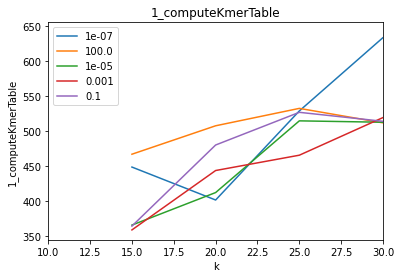

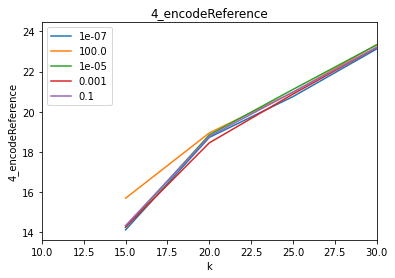

In [11]:
df = df_total.loc[:, PARAMS + SERVER_PREPROCESS]
df[SERVER_PREPROCESS] = df[SERVER_PREPROCESS] / 1000
print(df)
# draw k-x plot for x=[SERVER_PREPROCESS] for each threshold (all threshold in one plot)
# for each algorithm(column), plot all k-x plot for each threshold in one plot
for param in SERVER_PREPROCESS:
    plotEachColumn(df, param, "SERVER_PREPROCESS")

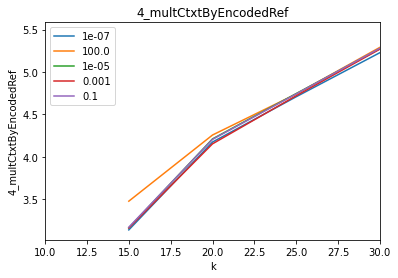

In [12]:
df = df_total.loc[:, PARAMS + SERVER_COPMUTATION]
df[SERVER_COPMUTATION] = df[SERVER_COPMUTATION] / 1000
df
for param in SERVER_COPMUTATION:
    plotEachColumn(df, param, "SERVER_COPMUTATION")

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e-01     1.0   5000.0        250    61164530.0   
0  25.0  1.000000e-05     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e+02     1.0   5000.0        250    61817026.

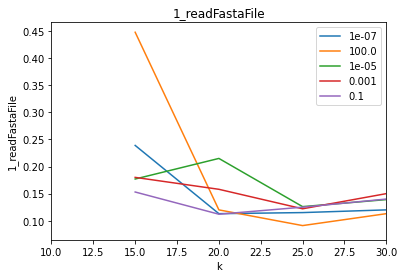

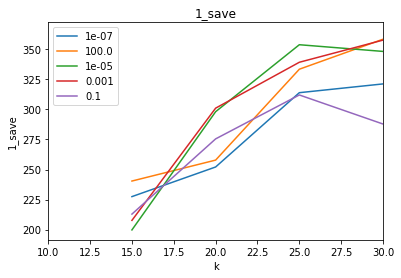

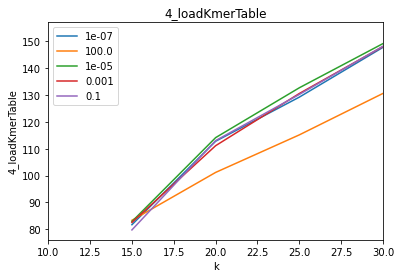

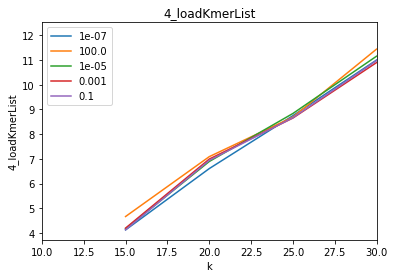

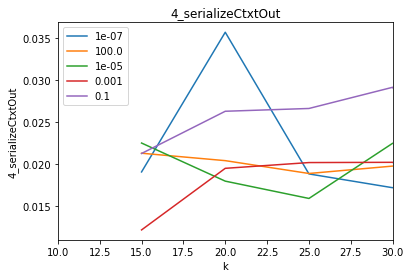

In [13]:
df = df_total.loc[:, PARAMS + SERVER_SAVE_LOAD]
df[SERVER_SAVE_LOAD] = df[SERVER_SAVE_LOAD] / 1000
df["total"] = df[SERVER_SAVE_LOAD].sum(axis=1)
print(df)
for param in SERVER_SAVE_LOAD:
    plotEachColumn(df, param, "SERVER_SAVE_LOAD")

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e-01     1.0   5000.0        250    61164530.0   
0  25.0  1.000000e-05     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e+02     1.0   5000.0        250    61817026.

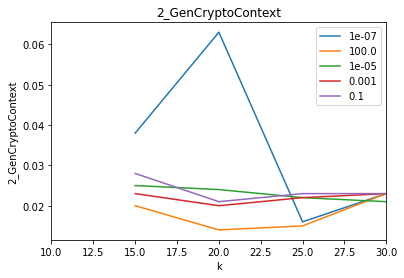

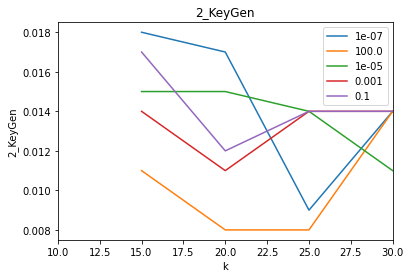

In [14]:
df = df_total.loc[:, PARAMS + USER_HE_GEN]
df[USER_HE_GEN] = df[USER_HE_GEN] / 1000
print(df)
for param in USER_HE_GEN:
    plotEachColumn(df, param, "USER_HE_GEN")

      k         thres  target  n_genes  num_batch  n_kmer_total  3_encodeRead  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0         2.244   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0         2.374   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0         2.226   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0         2.237   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0         2.228   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0         2.281   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0         2.472   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0         2.326   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0         2.272   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0         2.367   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0         1.932   
0  25.0  1.000000e-01     1.

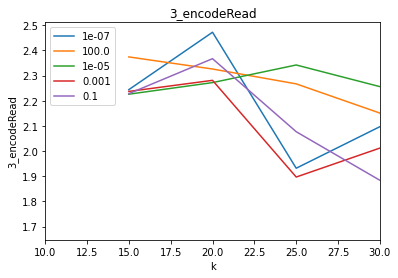

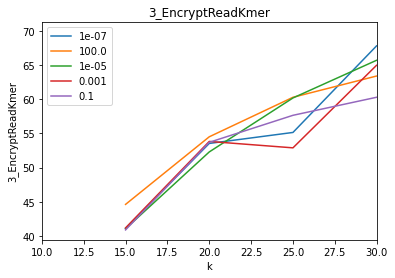

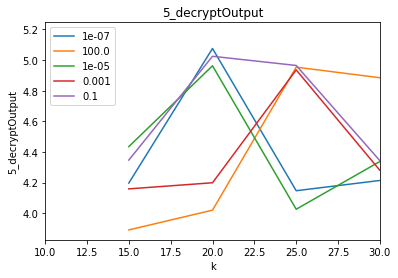

In [15]:
df = df_total.loc[:, PARAMS + USER_ENCRYPT + USER_DECRYPT]
df[USER_ENCRYPT + USER_DECRYPT] = df[USER_ENCRYPT + USER_DECRYPT] / 1000
print(df)
for param in USER_ENCRYPT + USER_DECRYPT:
    plotEachColumn(df, param, "USER_ENCRYPT + USER_DECRYPT")

      k         thres  target  n_genes  num_batch  n_kmer_total  2_Serialize  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0        0.105   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0        0.017   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0        0.022   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0        0.023   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0        0.026   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0        0.014   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0        0.021   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0        0.017   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0        0.018   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0        0.013   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0        0.036   
0  25.0  1.000000e-01     1.0   5000.0  

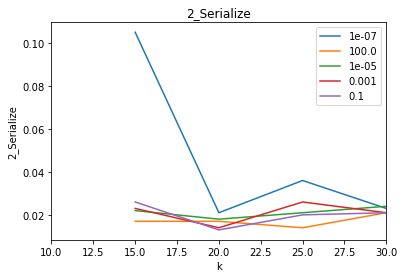

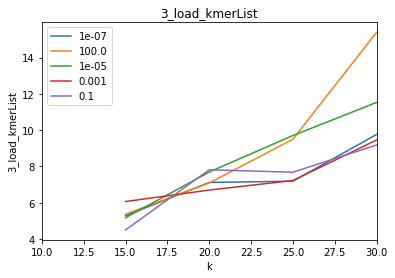

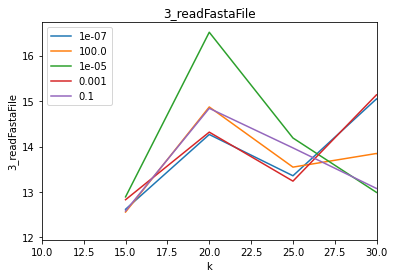

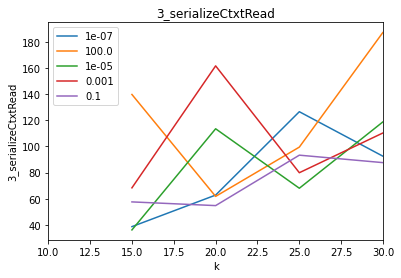

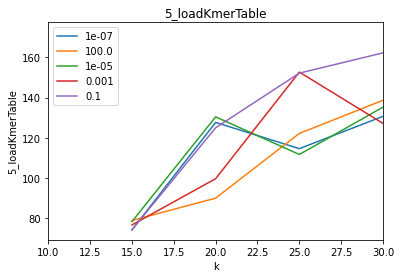

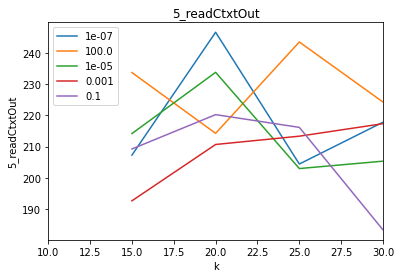

In [16]:
df = df_total.loc[:, PARAMS + USER_SAVE_LOAD]
df[USER_SAVE_LOAD] = df[USER_SAVE_LOAD] / 1000
df["total"] = df[USER_SAVE_LOAD].sum(axis=1)
print(df)
for param in USER_SAVE_LOAD:
    plotEachColumn(df, param, "USER_SAVE_LOAD")

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e-01     1.0   5000.0        250    61164530.0   
0  25.0  1.000000e-05     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e+02     1.0   5000.0        250    61817026.

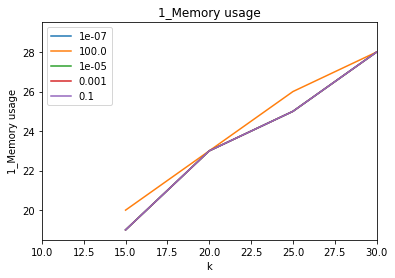

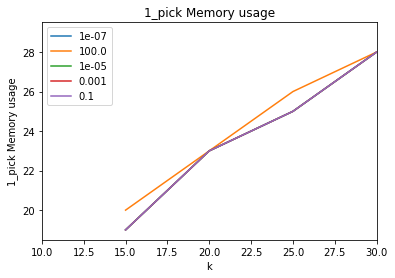

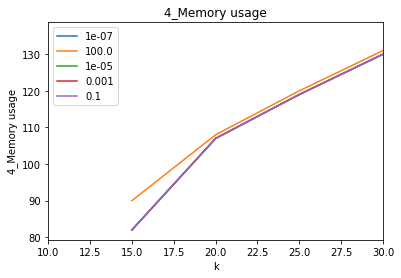

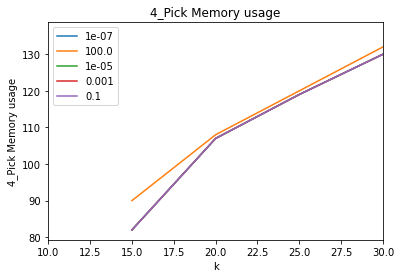

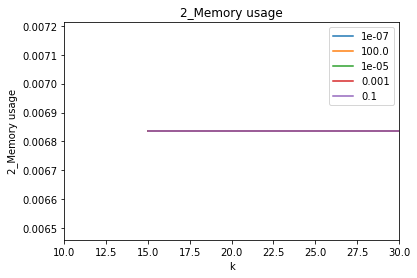

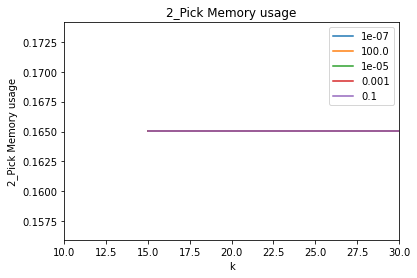

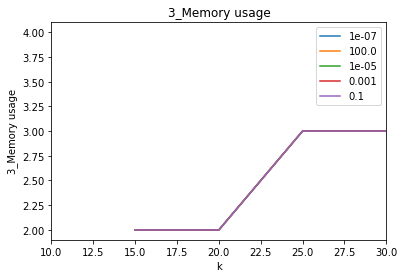

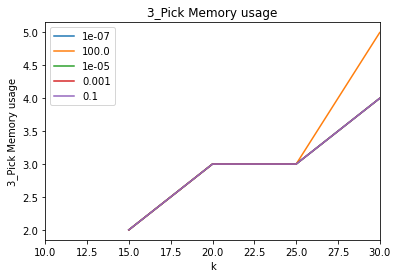

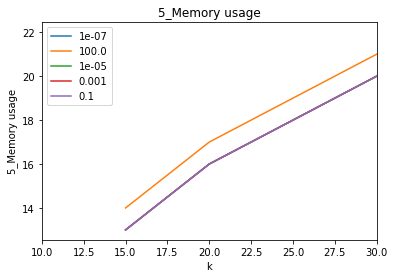

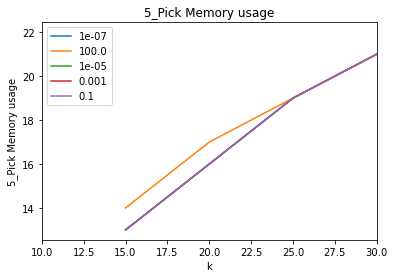

In [17]:
df = df_total.loc[:, PARAMS + SERVER_MEMORY + USER_MEMORY]
df["SERVER_MEM_TOTAL"] = df[SERVER_MEMORY].sum(axis=1)
df["USER_MEM_TOTAL"] = df[USER_MEMORY].sum(axis=1)
print(df)
for param in SERVER_MEMORY + USER_MEMORY:
    plotEachColumn(df, param, "SERVER_MEMORY + USER_MEMORY")

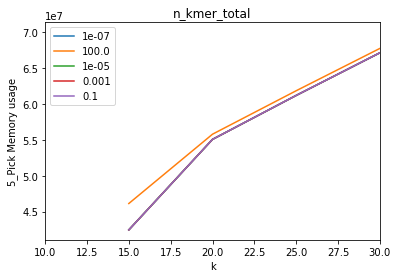

In [19]:
df = df_total.loc[:, PARAMS]
plotEachColumn(df, param, "SERVER_MEMORY + USER_MEMORY")